In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image = nib.load('/Users/matthewhunt/Desktop/Wash U stuff/Research Stuff/Image Files 10_20/TCGA-06-0138_first_ten_cases/TCGA-06-0139_1.3.6.1.4.1.14519.5.2.1.4591.4001.229090327759241505815737823916.4dfp.nii.gz')
next_header = image.header
next_affine = image.affine
side_len = 512


one_slice = image.dataobj[200:200+side_len,200:200+side_len,30]
full_image = image.get_data()

In [3]:
print(full_image.shape)
full_image = np.rollaxis(full_image,2)
print(full_image.shape)




(512, 512, 71)
(71, 512, 512)


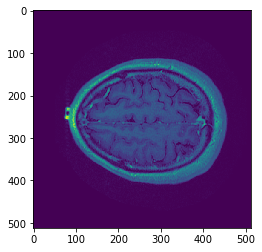

In [5]:

plt.imshow(full_image[54])
plt.show()
#25 about marks brain start

In [6]:
# Now for the convolutional AE.

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(side_len, side_len, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu',padding = 'same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
for i in range(len(autoencoder.layers)):
    print(autoencoder.layers[i].output_shape)

#Ah, the layer dims never matched up bc we had an even number throughout.
# Thus I had to add 'same' padding to all of them.

Using TensorFlow backend.


(None, 512, 512, 1)
(None, 512, 512, 16)
(None, 256, 256, 16)
(None, 256, 256, 8)
(None, 128, 128, 8)
(None, 128, 128, 8)
(None, 64, 64, 8)
(None, 64, 64, 8)
(None, 128, 128, 8)
(None, 128, 128, 8)
(None, 256, 256, 8)
(None, 256, 256, 16)
(None, 512, 512, 16)
(None, 512, 512, 1)


In [7]:

x_train = full_image[25:50].astype('float32')/np.amax(full_image)
x_test = full_image[50:55].astype('float32')/np.amax(full_image)
x_train = np.reshape(x_train, (x_train.shape[0], side_len, side_len, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (x_test.shape[0], side_len, side_len, 1))  # adapt this if using `channels_first` image data format 
# This 1 at the end refers to there being one channel.



(5, 512, 512, 1)
(25, 512, 512, 1)


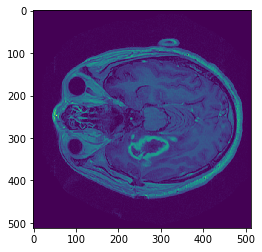

In [8]:
print(x_test.shape)
print(x_train.shape)
plt.imshow(x_train[1,:,:,0])
plt.show()

In [10]:
autoencoder.fit(x_train, x_train,
                epochs=125,
                batch_size=26,
                shuffle=True,
                validation_data=(x_test, x_test))
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 25 samples, validate on 5 samples
Epoch 1/125
25/25 [==============================] - 29s - loss: 0.6917 - val_loss: 0.6908
Epoch 2/125
25/25 [==============================] - 26s - loss: 0.6908 - val_loss: 0.6891
Epoch 3/125
25/25 [==============================] - 24s - loss: 0.6889 - val_loss: 0.6870
Epoch 4/125
25/25 [==============================] - 27s - loss: 0.6869 - val_loss: 0.6841
Epoch 5/125
25/25 [==============================] - 24s - loss: 0.6840 - val_loss: 0.6801
Epoch 6/125
25/25 [==============================] - 26s - loss: 0.6799 - val_loss: 0.6747
Epoch 7/125
25/25 [==============================] - 28s - loss: 0.6743 - val_loss: 0.6662
Epoch 8/125
25/25 [==============================] - 43s - loss: 0.6655 - val_loss: 0.6535
Epoch 9/125
25/25 [==============================] - 40s - loss: 0.6523 - val_loss: 0.6333
Epoch 10/125
25/25 [==============================] - 37s - loss: 0.6316 - val_loss: 0.6015
Epoch 11/125
25/25 [==========================

In [11]:
from keras.models import load_model

autoencoder.save('ConvAE_brain_1_full_slices.h5')  # creates a HDF5 file 'my_model.h5'
# del autoencoder  # deletes the existing model

# returns a compiled model
# identical to the previous one


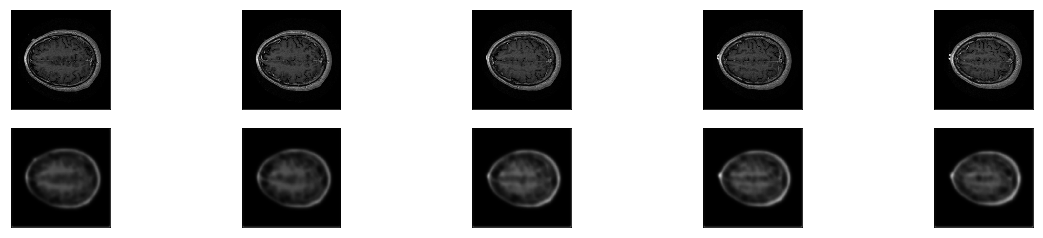

In [12]:
decoded_imgs = autoencoder.predict(x_test)


n = 5  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

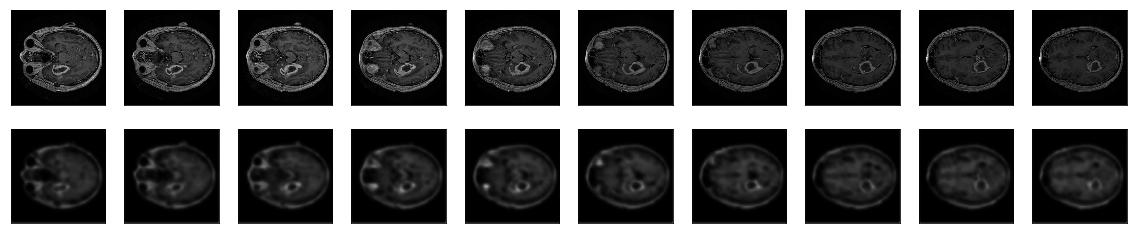

In [13]:
decoded_imgs_train = autoencoder.predict(x_train)


n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_train[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
encoder = Model(input_img,encoded)
encoded_imgs = encoder.predict(x_test)



In [ ]:
encoded_imgs.shape

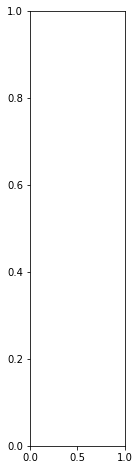

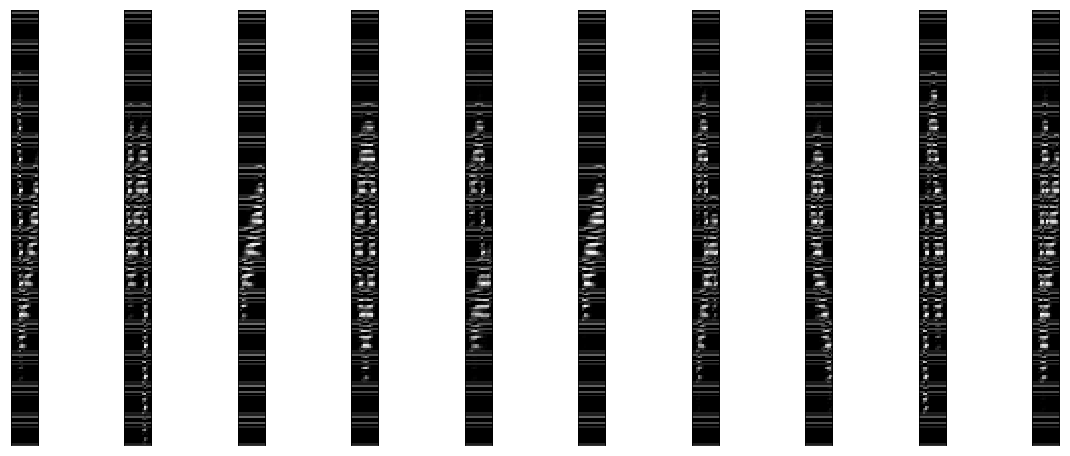

In [126]:
n = 10
plt.figure(figsize=(20, 8))
side_len = encoded_imgs.shape[1]
depth = encoded_imgs.shape[-1]
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(side_len, side_len * depth).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [112]:
for i in range(len(autoencoder.layers)):
    print(autoencoder.layers[i].output_shape)



(None, 28, 28, 1)
(None, 28, 28, 16)
(None, 14, 14, 16)
(None, 14, 14, 8)
(None, 7, 7, 8)
(None, 7, 7, 8)
(None, 4, 4, 8)
(None, 4, 4, 8)
(None, 8, 8, 8)
(None, 8, 8, 8)
(None, 16, 16, 8)
(None, 14, 14, 16)
(None, 28, 28, 16)
(None, 28, 28, 1)


In [130]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(encoded_imgs[1].reshape(side_len, side_len * depth).T)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig('encoded_image.png')